In [19]:
import pypsa
import pandas as pd

# Initialise Network and Load Data

In [195]:
network = pypsa.Network()

In [196]:
buses = pd.read_csv("../data/grid/buses.csv")
lines = pd.read_csv("../data/grid/lines.csv")
gens = pd.read_csv("../data/grid/generators.csv")

# Buses

Buses are sliced to be NEM only, and an example is plotted.

In [175]:
# drop duplicates and substations without names
buses = buses[~buses["name"].duplicated(keep="first")]
buses.dropna(subset="name",inplace=True)

# clean buses to be NEM only
buses = buses[buses['X'] > 135.4] # examine NEM only
# Manually removed the following:
# 1112,136.308126381,-16.054206259,1113,Substation,,2018_Borroloola,Operational,Northern Territory,3,1637193600000.0,{111516C8-BFA8-463D-AC10-8562A6C73AF9},"A structure in which high voltage electricity supply is converted, controlled or transformed",,Borroloola,,136.30812638,-16.05420626,"136.30812638,-16.05420626"
# 1111,136.442266771,-13.978625017,1112,Substation,,2017_Angurugu,Operational,Northern Territory,3,1637193600000.0,{6DA3E905-85F0-4949-ACA8-9CCEC5657817},"A structure in which high voltage electricity supply is converted, controlled or transformed",,Anindilyakwa,,136.44226677,-13.97862502,"136.44226677,-13.97862502"
# 1110,136.781691928,-12.186985578,1111,Substation,,2018_Nhulunbuy_,Operational,Northern Territory,2,1637193600000.0,{A4E48E1A-A74A-4423-84B9-22A27FD0CDFF},"A structure in which high voltage electricity supply is converted, controlled or transformed",,Nhulunbuy,,136.78169193,-12.18698558,"136.78169193,-12.18698558"
buses.reset_index(drop=True,inplace=True)
buses['rowno'] = buses.index

# some voltages are missing, so these are added as a filler.
# buses = buses[buses.voltagekv.isnull()]
buses.fillna(132,inplace=True)

# check that all bus names are distinct before setting as index.
if buses.name.nunique()==len(buses.index):
    print("Bus names are distinct.")
    buses.set_index("name",inplace=True)

Bus names are distinct.


In [176]:
# add buses to PyPSA network
for bus in buses.index:
    network.add("Bus",bus, v_nom = buses.at[bus,"voltagekv"])

# check by printing buses
print(network.buses)

                v_nom type    x    y carrier unit  v_mag_pu_set  v_mag_pu_min  \
Bus                                                                             
Clermont        132.0       0.0  0.0      AC                1.0           0.0   
Bullyard         66.0       0.0  0.0      AC                1.0           0.0   
Pialba           66.0       0.0  0.0      AC                1.0           0.0   
Isis River       66.0       0.0  0.0      AC                1.0           0.0   
Point Vernon     66.0       0.0  0.0      AC                1.0           0.0   
...               ...  ...  ...  ...     ...  ...           ...           ...   
Mount Mercer    132.0       0.0  0.0      AC                1.0           0.0   
Tomerong        132.0       0.0  0.0      AC                1.0           0.0   
Hampshire       110.0       0.0  0.0      AC                1.0           0.0   
Clifford Creek  132.0       0.0  0.0      AC                1.0           0.0   
City Central    132.0       

In [177]:
import plotly.express as px

# Create the interactive scatter map plot
fig = px.scatter_mapbox(
    buses, lat='Y', lon='X',
    size='voltagekv',  # Scale markers by size
    text=buses.index,  # Show name on hover
    hover_name=buses.index,  # Display name on hover
    size_max=15,  # Adjust max size for visibility
    mapbox_style= 'open-street-map'# "carto-positron",  # Choose a map style (other options: 'open-street-map', 'stamen-terrain', etc.)
)

# Customize layout
fig.update_layout(
    title="Scaled Scatter Plot on Map of Australia",
    geo=dict(
        scope="asia",  # You can specify 'australia' for a more focused region if using Plotly's geo support
        center=dict(lat=-25.2744, lon=133.7751),  # Center the map on Australia
        projection_scale=10 # Adjust the zoom level for better visibility
    ),
     mapbox=dict(
        zoom=4  # Decrease zoom level
    ),
    width=1200,  # Adjust the width of the output box
    height=800  # Adjust the height of the output box
)

# Show interactive map plot
fig.show()


# Generators

Generators are matched by location to the nearest bus.

In [178]:
def find_nearest_bus(bdf, name, x, y):
    '''
    Finds the nearest bus_id from buses df

    Parameters
    ----------
    bdf : pandas dataframe
        dataframe which includes the x,y coordinates of the buses.
    name : name of generator
    

    Returns
    -------
    int
        returns the bus_id closest to the power station (heuristic)
    '''
    try:
        xbus, ybus = bdf.at[name,"X"], bdf.at[name,"Y"]

        if (xbus-x)**2 + (ybus-y)**2 < 1:
            return name, xbus, ybus
        
        else:
            nearestBus = "N/A"
            xmin,ymin = 100,100
            xbusmin,xbusmax=100,100

            for bus_name in bdf.index:
                xbus = bdf.at[bus_name,'X']
                ybus = bdf.at[bus_name,'Y']
                
                xt = x-xbus
                yt = y-ybus

                if (xt**2 + yt**2) < (xmin**2 + ymin**2): # totalmin
                    xmin,ymin = xt,yt
                    xbusmin,xbusmax = xbus,ybus
                    
                    nearestBus = bus_name

            return nearestBus,xbusmin,xbusmax

    except KeyError:
        nearestBus = "N/A"
        xmin,ymin = 100,100
        xbusmin,xbusmax=100,100

        for bus_name in bdf.index:
            xbus = bdf.at[bus_name,'X']
            ybus = bdf.at[bus_name,'Y']
            
            xt = x-xbus
            yt = y-ybus

            if (xt**2 + yt**2) < (xmin**2 + ymin**2): # totalmin
                xmin,ymin = xt,yt
                xbusmin,xbusmax = xbus,ybus
                
                nearestBus = bus_name

        return nearestBus,xbusmin,xbusmax

In [179]:
gens = gens[gens['X'] > 135.4] # examine NEM only
gens.reset_index(drop=True,inplace=True)

# check that all gen names are distinct
if gens.name.nunique()==len(gens.index):
    print("Generator names are distinct.")

Generator names are distinct.


In [ ]:
# gens[gens.name.duplicated()]
# Manually removed gens with lower spatial confidence
# 53,138.732338977,-33.3397200429999,54,Power Station,A facility used for the generation of electrical power for distribution,Renewable,Hallett 1 Brown Hill  Wind Farm,Operational,AGL Energy Pty Ltd,Wind Turbine,Wind,,94.5,45.0,Canowie,South Australia,2,1479945600000,{D68EA842-70BD-49D7-811A-F85A899C8A7B},Wind,138.73233898,-33.33972004,
# 55,138.855167053,-33.522588905,56,Power Station,A facility used for the generation of electrical power for distribution,Renewable,Hallett 2 Hallet Hill  Wind Farm,Operational,ANZ Energy Infrastructure Trust,Wind Turbine,Wind,,71.4,34.0,North Booborowie,South Australia,2,1479945600000,{7019F9C1-D172-45C8-A44A-B7746FA2425E},Wind,138.85516705,-33.52258891,
# 485,149.459748913,-34.614903937,486,Power Station,A facility used for the generation of electrical power for distribution,Renewable,Gullen Range Wind Farm,Operational,Tianrun Australia,Wind Turbine,Wind,,165.5,73.0,Bannister,New South Wales,3,1479945600000,{370AF3B1-08FA-4689-B747-84C7C83112F8},,149.45974891,-34.61490394,"149.45768718,-34.61402868"

In [ ]:
# add generators to the PyPSA network
for gen in gens.index:
    xc,yc = gens.at[gen,"X"],gens.at[gen,"Y"]
    bus,_,_ = find_nearest_bus(buses,gen,xc,yc)
    gens.at[gen,"nearest_bus"] = bus
    name = gens.at[gen,"name"]
    capacity = gens.at[gen,"generationmw"]
    network.add("Generator",name,bus=bus,p_max_pu=capacity)

# Lines

Inherent problem with lines method which splits the line name on "to" but some lines are described as the locality it is in.

An example is:

Taree to Stroud -> Taree (bus0), Stroud (bus1)

One that fails is:

Wagga 132 -> Wagga 123 (bus0), NaN

In [181]:
# lines[lines.bus_1.isnull()]
# There are 103 rows which are not considered
lines.dropna(subset=["bus_0","bus_1"],inplace=True)
lines[['X0','Y0']] = lines['location_0'].str.split(",",expand=True)
lines['X0'] = lines['X0'].astype(float)
lines['Y0'] = lines['Y0'].astype(float)
lines[['X1','Y1']] = lines['location_1'].str.split(",",expand=True)
lines['X1'] = lines['X1'].astype(float)
lines['Y1'] = lines['Y1'].astype(float)
# NEM only
c0 = (lines.X0 > 135.4)
c1 = (lines.X1 > 135.4)
lines = lines.loc[c0 & c1]
lines.reset_index(drop=True,inplace=True)


In [182]:
if len(lines) == lines.name.nunique():
    print("Line names are distinct")

Line names are distinct


In [ ]:
# add lines to the PyPSA network
for line in lines.index:
    name = lines.at[line,"name"] # get the full line name
    line0 = lines.at[line,"bus_0"] # gets the starting bus name
    line1 = lines.at[line,"bus_1"] # gets the destination bus name
    xc0,yc0 = lines.at[line,"X0"], lines.at[line,"Y0"]
    xc1,yc1 = lines.at[line,"X1"], lines.at[line,"Y1"]
    bus0,_,_ = find_nearest_bus(buses,line0,xc0,yc0)
    bus1,_,_ = find_nearest_bus(buses,line1,xc1,yc1)
    network.add("Line",
                name = name,
                bus0 = bus0,
                bus1 = bus1,
                x    = 0.1,
                r    = 0.01)

In [ ]:
network.add()

In [184]:
network.add("Load",network.buses.index + " load",bus=buses.index.to_numpy())

Index(['Clermont load', 'Bullyard load', 'Pialba load', 'Isis River load',
       'Point Vernon load', 'Howard load', 'Woodgate load', 'Childers load',
       'Wallaville load', 'Bargara load',
       ...
       'Clements Gap Wind Farm load', 'Kumbarilla Park load', 'Bluff load',
       'Eagles Downs load', 'Duaringa load', 'Mount Mercer load',
       'Tomerong load', 'Hampshire load', 'Clifford Creek load',
       'City Central load'],
      dtype='object', name='Bus', length=1478)

In [187]:
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
Clermont,132.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,0
Bullyard,66.0,,0.0,0.0,AC,,1.0,0.0,inf,Slack,None,1
Pialba,66.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,0
Isis River,66.0,,0.0,0.0,AC,,1.0,0.0,inf,Slack,370,2
Point Vernon,66.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Mount Mercer,132.0,,0.0,0.0,AC,,1.0,0.0,inf,Slack,19,571
Tomerong,132.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,0
Hampshire,110.0,,0.0,0.0,AC,,1.0,0.0,inf,Slack,None,572


In [185]:
network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network <pypsa.components.SubNetwork object at 0x140540fd0> for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Balancing power on single-bus sub-network <pypsa.components.SubNetwork object at 0x14cadef90> for snapshots Index(['now'], dtype='object', name='snapshot')


KeyError: None

# Hobart Test Run

In [200]:
import pypsa
import pandas as pd
import plotly.express as px
import numpy as np

In [262]:
def find_nearest_bus(bdf, name, x, y):
    '''
    Finds the nearest bus_id from buses df

    Parameters
    ----------
    bdf : pandas dataframe
        dataframe which includes the x,y coordinates of the buses.
    name : name of generator
    

    Returns
    -------
    int
        returns the bus_id closest to the power station (heuristic)
    '''
    try:
        xbus, ybus = bdf.at[name,"X"], bdf.at[name,"Y"]

        if (xbus-x)**2 + (ybus-y)**2 < 1:
            return name, xbus, ybus
        
        else:
            nearestBus = "N/A"
            xmin,ymin = 100,100
            xbusmin,xbusmax=100,100

            for bus_name in bdf.index:
                xbus = bdf.at[bus_name,'X']
                ybus = bdf.at[bus_name,'Y']
                
                xt = x-xbus
                yt = y-ybus

                if (xt**2 + yt**2) < (xmin**2 + ymin**2): # totalmin
                    xmin,ymin = xt,yt
                    xbusmin,xbusmax = xbus,ybus
                    
                    nearestBus = bus_name

            return nearestBus,xbusmin,xbusmax

    except KeyError:
        nearestBus = "N/A"
        xmin,ymin = 100,100
        xbusmin,xbusmax=100,100

        for bus_name in bdf.index:
            xbus = bdf.at[bus_name,'X']
            ybus = bdf.at[bus_name,'Y']
            
            xt = x-xbus
            yt = y-ybus

            if (xt**2 + yt**2) < (xmin**2 + ymin**2): # totalmin
                xmin,ymin = xt,yt
                xbusmin,xbusmax = xbus,ybus
                
                nearestBus = bus_name

        return nearestBus,xbusmin,xbusmax

def hobart_bubble(buses,lines,gens):
    lines.dropna(subset=["bus_0","bus_1"],inplace=True)
    lines[['X0','Y0']] = lines['location_0'].str.split(",",expand=True)
    lines['X0'] = lines['X0'].astype(float)
    lines['Y0'] = lines['Y0'].astype(float)
    lines[['X1','Y1']] = lines['location_1'].str.split(",",expand=True)
    lines['X1'] = lines['X1'].astype(float)
    lines['Y1'] = lines['Y1'].astype(float)
    buses = buses.loc[(buses['Y'].astype(float) < -42.12) & (buses['X'].astype(float)  > 145.98)] # Hobart test case
    lines = lines.loc[(lines['Y0'] < -42.12) & (lines['X0'] > 145.98)
                & (lines['Y1'] < -42.12) & (lines['X1'] > 145.98)] # Hobart test case
    gens = gens.loc[(gens['Y'].astype(float) < -42.12) & (gens['X'].astype(float) > 145.98)] # Hobart test case
    return buses.copy(),lines.copy(),gens.copy()

def clean_buses(buses):
    # drop duplicates and substations without names
    buses = buses.loc[~buses["name"].duplicated(keep="first")]
    buses.dropna(subset="name",inplace=True)
    buses.reset_index(drop=True,inplace=True)
    buses['rowno'] = buses.index
    # some voltages are missing, so these are added as a filler.
    # buses = buses[buses.voltagekv.isnull()]
    buses.fillna(132,inplace=True)
    # check that all bus names are distinct before setting as index.
    if buses.name.nunique()==len(buses.index):
        print("Bus names are distinct.")
        buses.set_index("name",inplace=True)
    return buses.copy()

def add_buses_to_network(buses):
    # add buses to PyPSA network
    for bus in buses.index:
        network.add("Bus",bus, v_nom = buses.at[bus,"voltagekv"])
    print("Done adding buses.")
    return buses.copy()

def add_generators_to_network(gens):
    gens.reset_index(drop=True,inplace=True)
    # check that all gen names are distinct
    if gens.name.nunique()==len(gens.index):
        print("Generator names are distinct.")
    # add generators to the PyPSA network
    for gen in gens.index:
        xc,yc = gens.at[gen,"X"],gens.at[gen,"Y"]
        bus,_,_ = find_nearest_bus(buses,gen,xc,yc)
        gens.at[gen,"nearest_bus"] = bus
        name = gens.at[gen,"name"]
        capacity = gens.at[gen,"generationmw"]
        network.add("Generator",name,bus=bus,p_nom=capacity)
    
    print("Done adding generators.")
    return gens.copy()

def add_lines_to_network(lines):
    # add lines to the PyPSA network
    for line in lines.index:
        name = lines.at[line,"name"] # get the full line name
        line0 = lines.at[line,"bus_0"] # gets the starting bus name
        line1 = lines.at[line,"bus_1"] # gets the destination bus name
        xc0,yc0 = lines.at[line,"X0"], lines.at[line,"Y0"]
        xc1,yc1 = lines.at[line,"X1"], lines.at[line,"Y1"]
        bus0,_,_ = find_nearest_bus(buses,line0,xc0,yc0)
        bus1,_,_ = find_nearest_bus(buses,line1,xc1,yc1)
        network.add("Line",
                    name = name,
                    bus0 = bus0,
                    bus1 = bus1,
                    x    = 0.1,
                    r    = 0.01)
    print("Done adding lines.")
    return lines.copy()

def add_loads_to_network(buses):
    # add loads
    ps = np.random.randint(5,11,len(buses))
    qs = np.random.randint(-10,11,len(buses))
    network.add("Load",network.buses.index + " load",
                bus=buses.index.to_numpy(),p_set=ps,q_set=qs,
                overwrite=True)
    return None

In [263]:
network = pypsa.Network()

buses = pd.read_csv("../data/test/buses.csv")
lines = pd.read_csv("../data/test/lines.csv")
gens = pd.read_csv("../data/test/gens.csv")

print(gens.head())

# print("cleaning buses")

# b = clean_buses(buses)

# print("buses are squeaky clean")

# b,l,g = hobart_bubble(b,lines,gens)

# b.to_csv("../data/test/buses.csv",index=False)
# l.to_csv("../data/test/lines.csv",index=False)
# g.to_csv("../data/test/gens.csv",index=False)

# print(g)

# print("creating map")

b = add_buses_to_network(buses)

l = add_lines_to_network(lines)

g = add_generators_to_network(gens)

d = add_loads_to_network(b)

print(network)

# print(network.pf())

   Unnamed: 0           X          Y  objectid    featuretype  \
0           0  146.646965 -42.507682         1  Power Station   
1           1  145.982837 -42.740505         2  Power Station   
2          14  146.620704 -42.253689        15  Power Station   
3          91  146.262888 -42.268574        92  Power Station   
4         163  146.534714 -42.427163       164  Power Station   

                                         description      class       name  \
0  A facility used for the generation of electric...  Renewable    Repulse   
1  A facility used for the generation of electric...  Renewable     Gordon   
2  A facility used for the generation of electric...  Renewable  Lake Echo   
3  A facility used for the generation of electric...  Renewable  Nieterana   
4  A facility used for the generation of electric...  Renewable  Wayatinah   

  operationalstatus                                  owner  ...  \
0       Operational  Hydro-Electric Corporation (Tasmania)  ...   
1     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



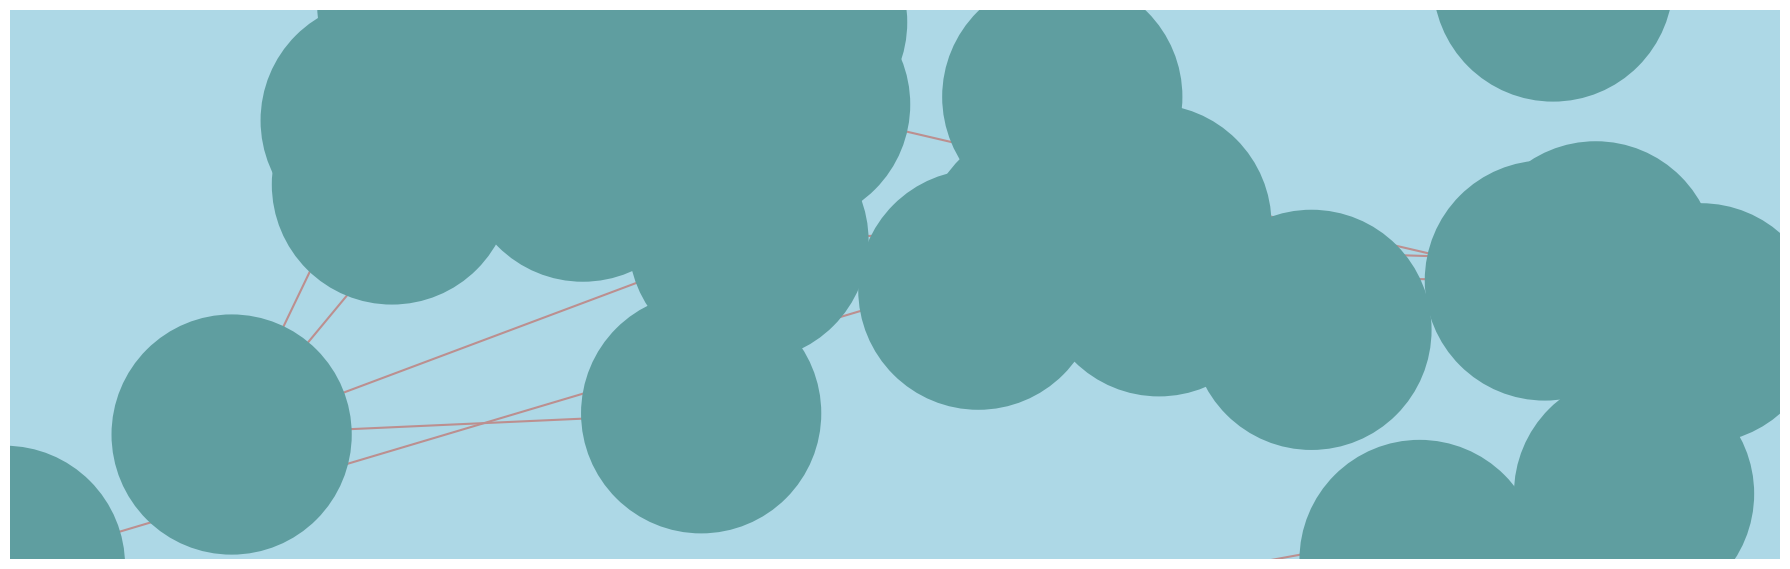

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(18, 18))
network.plot(
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()

In [243]:
def create_interactive_map(df):
    # Create the interactive scatter map plot
    fig = px.scatter_mapbox(
        df, lat='Y', lon='X',
        size='voltagekv',  # Scale markers by size
        text=df.index,  # Show name on hover
        hover_name=df.index,  # Display name on hover
        size_max=15,  # Adjust max size for visibility
        mapbox_style= 'open-street-map'# "carto-positron",  # Choose a map style (other options: 'open-street-map', 'stamen-terrain', etc.)
    )

    # Customize layout
    fig.update_layout(
        title="Scaled Scatter Plot on Map of Australia",
        geo=dict(
            scope="asia",  # You can specify 'australia' for a more focused region if using Plotly's geo support
            center=dict(lat=-25.2744, lon=133.7751),  # Center the map on Australia
            projection_scale=10 # Adjust the zoom level for better visibility
        ),
        mapbox=dict(
            zoom=4  # Decrease zoom level
        ),
        width=1200,  # Adjust the width of the output box
        height=800  # Adjust the height of the output box
    )

    # Show interactive map plot
    fig.show()

create_interactive_map(buses)

Done adding buses.
Done adding lines.
Generator names are distinct.
Done adding generators.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:857: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



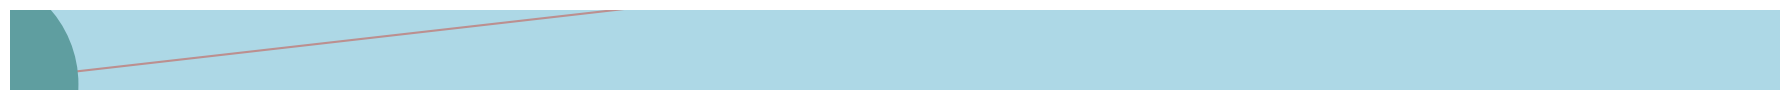

In [272]:
network = pypsa.Network()

buses = pd.read_csv("../data/simple/buses.csv",index_col=0)
lines = pd.read_csv("../data/simple/lines.csv")
gens = pd.read_csv("../data/simple/gens.csv")

# print(buses.head())

b = add_buses_to_network(buses)

l = add_lines_to_network(lines)

g = add_generators_to_network(gens)

# d = add_loads_to_network(b)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(18, 18))
network.plot(
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()

# print(network.pf())

In [273]:
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
Chapel Street,110.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,
Gordon,110.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,


In [274]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Gordon,Gordon,PQ,,432.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [275]:
network.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
Gordon to Chapel Street,Gordon,Chapel Street,,0.1,0.01,0.0,0.0,0.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
network.add("Load","Chapel Load",bus="Chapel Street",p_set = 100)
network.add("Load","Chapel Load 2",bus="Chapel Street",p_set = 50, q_set = 10)

Index(['Chapel Load 2'], dtype='object')

In [283]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
Chapel Load,Chapel Street,,,100.0,0.0,-1.0,True
Chapel Load 2,Chapel Street,,,50.0,10.0,-1.0,True


In [284]:
network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network <pypsa.components.SubNetwork object at 0x14cdc7690> for snapshots Index(['now'], dtype='object', name='snapshot')


{'n_iter': SubNetwork  0
 snapshot     
 now         2,
 'error': SubNetwork             0
 snapshot                
 now         7.836443e-08,
 'converged': SubNetwork     0
 snapshot        
 now         True}

In [286]:
network.lines_t.p0

,Gordon to Chapel Street
snapshot,
now,150.018685


In [287]:
network.buses_t.v_ang * 180 / np.pi

Bus,Chapel Street,Gordon
snapshot,,
now,-0.070569,0.0


In [288]:
network.buses_t.v_mag_pu

Bus,Chapel Street,Gordon
snapshot,,
now,0.999793,1.0


In [ ]:
# line bus function
def get_missing_buses():
    # interpolate missing bus capacities from surrounding buses
    # want to make sure bus0 to bus1 is done perfectly